# Unconstrained optimization problems

**Table of contents**<a id='toc0_'></a>    
- 1. [Introduction](#toc1_)    
- 2. [Gradient based optimizers](#toc2_)    
- 3. [Example 1: The rosenbrock function](#toc3_)    
- 4. [Gradient descent](#toc4_)    
- 5. [Scipy minimizers](#toc5_)    
- 6. [Controling the optimizers](#toc6_)    
- 7. [Example 2: Griewank function](#toc7_)    
  - 7.1. [3D plot](#toc7_1_)    
  - 7.2. [Multi-start](#toc7_2_)    
  - 7.3. [Is there a better solution than multi-start?](#toc7_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

You will learn to *numerically* solve *unconstrained* optimization problems (with **scipy.optimize**).

**scipy.optimize:** [overview](https://docs.scipy.org/doc/scipy/reference/optimize.html)

**Note:** [Unconstrained Numerical Optimization: An Introduction for Econometricians](https://www.dropbox.com/s/wjj5cvi3iz6pzs2/noteOptimization.pdf?dl=0) (by Anders Munk-Nielsen)

In [108]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

from scipy import linalg
from scipy import optimize

## 1. <a id='toc1_'></a>[Introduction](#toc0_)

All **optimization problems** are characterized by:

1. Control vector (choices/decisions), $\boldsymbol{x} \in \mathbb{R}^n$
2. Objective function (payoff/utility) to minimize, $f:\mathbb{R}^n \rightarrow \mathbb{R}$ (differentiable or not)
3. Constraints, i.e. $\boldsymbol{x}  \in C \subseteq \mathbb{R}^n$ (linear or non-linear interdependence) *[NOT TODAY]*

Note that $f$ might also take other inputs (parameters or a dataset).<br>
But these are fixed and therefore not variables we optimize over.

**Maximization** is just **minimization** of $-f$. 

All **optimizers** (minimizers) follow the structure:

1. Make initial guess
2. Evaluate the function (and perhaps gradients)
3. Check for convergence
4. Update guess and return to step 2

**What is convergence?** "Small" change in function value since last iteration (or "zero" gradient).

**Gradients** provide useful information, but can be costly to compute (using analytical formula or numerically).

Three usefull **optimizers** for unconstrained problems:

1. **Nelder-Mead:** 
 * **Pro:** Robust (to e.g. noise in objective function) and does not require derivatives.
 * **Con:** Slow convergence.
2. **Newton-CG:**
 * **Pro:** Require few iterations. Very precise with analytical hessian for smooth functions.
 * **Con:** Costly computation of hessian.
3. **BFGS:** (like newton, but with smart computation of hessian)
  * **Pro:** Require few function evaluations. 
  * **Con:** Slighly less smooth convergence.

## 2. <a id='toc2_'></a>[Gradient based optimizers](#toc0_)

Let us look at the idea behind gradient based optimizers.

**One dimensional intuition:** Consider the second-order Taylor approximation around $x_k$:

$$ 
f_T(x) = f_T(x_k + \Delta x) \approx f(x_k)+ f^{\prime}(x_k) \Delta x + \frac{1}{2} f^{\prime\prime}(x_k) (\Delta x)^2
$$

Find the minimum wrt. to $\Delta x$ by solving the FOC:

$$
\frac{d}{d\Delta x} f_T(x) = 0 \Leftrightarrow f^{\prime}(x_k) + f^{\prime\prime}(x_k) \Delta x = 0 \Leftrightarrow \Delta x = -\frac{f^{\prime}(x_k)}{f^{\prime\prime}(x_k)}
$$

**Algorithm:** `minimize_newton()`

1. Choose tolerance $\epsilon>0$, guess on $\boldsymbol{x}_0$, compute $f(\boldsymbol{x}_0)$, and set $k=1$.
2. Compute $\nabla f(\boldsymbol{x}_{k-1})$ (gradient/jacobian) and $\boldsymbol{H}f(\boldsymbol{x}_{k-1})$ (hessian).
3. Compute new guess

  $$ 
  \boldsymbol{x}_{k} = \boldsymbol{x}_{k-1} - [\boldsymbol{H}f(\boldsymbol{x}_{k-1})]^{-1} \nabla f(\boldsymbol{x}_{k-1})
  $$

3. If $|f(\boldsymbol{x}_k)-f(\boldsymbol{x}_{k-1})| < \epsilon$ then stop.
5. Set $k = k + 1$ and return to step 2.

In [109]:
def minimize_newton(f,x0,jac,hess,max_iter=500,tol=1e-8,use_solve=False):
    """ minimize function with Newtons' algorithm
        
    Args:

        f (callable): function
        x0 (np.ndarray): initial values
        jac (callable): jacobian
        hess (callable): hessian
        max_iter (int): maximum number of iterations
        tol (float): tolerance
        use_solve (bool): use solve instead of inverse
        
    Returns:
    
        x (np.ndarray): minimum
        nit (int): number of iterations used        
        
    """
    
    # step 1: initialize
    x = x0
    fx = f(x0)
    nit = 1
    
    # step 2-5: iteration
    while nit < max_iter:
        
        x_prev = x
        fx_prev = fx
        
        # step 2: evaluate gradient and hessian
        jacx = jac(x_prev)
        hessx = hess(x_prev)
        
        # step 3: update x
        if use_solve: # hessx@x = hessx@x_prev-jacx
            x = linalg.solve(hessx,hessx@x_prev-jacx)
        else: 
            inv_hessx = linalg.inv(hessx)        
            x = x_prev - inv_hessx@jacx
     
        # step 4: check convergence
        fx = f(x)
        if abs(fx-fx_prev) < tol:
            break
            
        # step 5: increment n
        nit += 1
        
    return x,nit

**Pause:** Spend some time looking at the `minimize_newton` function above.

## 3. <a id='toc3_'></a>[Example 1: The rosenbrock function](#toc0_)

Consider the **rosenbrock function**:

$$ 
f(\boldsymbol{x}) = f(x_1,x_2) =0.5(1-x_{1})^{2}+(x_{2}-x_{1}^{2})^{2}
$$

with **jacobian** (gradient)

$$ 
\nabla f(\boldsymbol{x})=\begin{bmatrix}\frac{\partial f}{\partial x_{1}}\\
\frac{\partial f}{\partial x_{2}}
\end{bmatrix}=\begin{bmatrix}-(1-x_{1})-4x_{1}(x_{2}-x_{1}^{2})\\
2(x_{2}-x_{1}^{2})
\end{bmatrix}
$$

and **hessian**:

$$
\boldsymbol{H}f(\boldsymbol{x})=\begin{bmatrix}\frac{\partial f}{\partial x_{1}x_{1}} & \frac{\partial f}{\partial x_{1}x_{2}}\\
\frac{\partial f}{\partial x_{1}x_{2}} & \frac{\partial f}{\partial x_{2}x_{2}}
\end{bmatrix}=\begin{bmatrix}1-4x_{2}+12x_{1}^{2} & -4x_{1}\\
-4x_{1} & 2
\end{bmatrix}
$$

**Global minimum** is at $(1,1)$ where $f(1,1)=0$.

**Implementation:**

In [110]:
def _rosen(x1,x2):
    return 0.5*(1.0-x1)**2+(x2-x1**2)**2
def rosen(x):
    return _rosen(x[0],x[1])
def rosen_jac(x):
    return np.array([-(1.0-x[0])-4*x[0]*(x[1]-x[0]**2),2*(x[1]-x[0]**2)])
def rosen_hess(x):
    return np.array([[1-4*x[1]+12*x[0]**2,-4*x[0]],[-4*x[0],2]])

**3D Plot:**

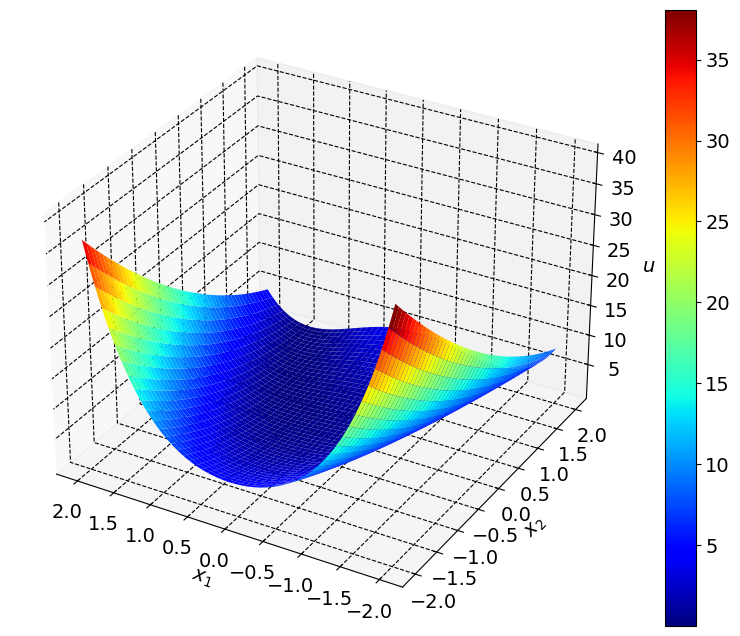

In [111]:
# a. grids
x1_vec = np.linspace(-2,2,500)
x2_vec = np.linspace(-2,2,500)
x1_grid,x2_grid = np.meshgrid(x1_vec,x2_vec,indexing='ij')
rosen_grid = _rosen(x1_grid,x2_grid)

# b. main
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(x1_grid,x2_grid,rosen_grid,cmap=cm.jet)

# c. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$u$')

# d. invert xaxis
ax.invert_xaxis()

# e. add colorbar
fig.colorbar(cs);

**Contour plot:**

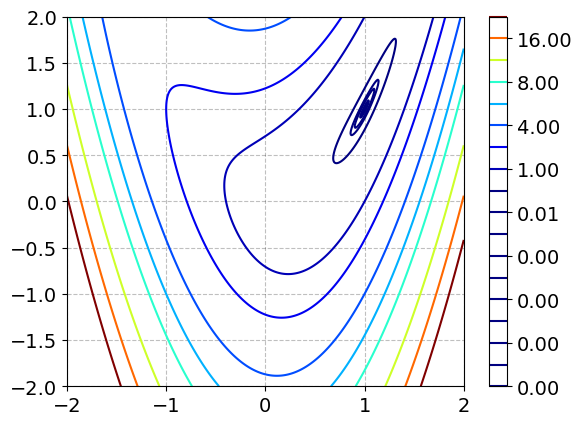

In [112]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
levels = [1e-6,5*1e-6,1e-5,5*1e-5,1e-4,5*1e-4,1e-3,5*1e-3,1e-2,5*1e-2,1,2,4,6,8,12,16,20]
cs = ax.contour(x1_grid,x2_grid,rosen_grid,levels=levels,cmap=cm.jet)
fig.colorbar(cs);

**Newton:**

In [113]:
x0 = np.array([5,5])
x,nit = minimize_newton(rosen,x0,rosen_jac,rosen_hess)
print(nit,x,rosen(x))

6 [1. 1.] 0.0


with `use_solve=True`

In [114]:
x0 = np.array([5,5])
x,nit = minimize_newton(rosen,x0,rosen_jac,rosen_hess,use_solve=True)
print(nit,x,rosen(x))

6 [1. 1.] 0.0


## 4. <a id='toc4_'></a>[Gradient descent](#toc0_)

**Algorithm:** `minimize_gradient_descent()`

1. Choose tolerance $\epsilon>0$, potential step sizes, $ \boldsymbol{\alpha} = [\alpha_0,\alpha_1,\dots,\alpha_\#]$, guess on $\boldsymbol{x}_0$, compute $f(\boldsymbol{x}_0)$, and set $k=1$.
2. Compute $\nabla f(\boldsymbol{x}_{k-1})$.
3. Find good step size:

  $$ 
  \alpha^{\ast} = \arg \min_{\alpha \in \boldsymbol{\alpha}}  f(\boldsymbol{x}_{k-1} - \alpha \nabla f(\boldsymbol{x}_{k-1}))
  $$

4. Compute new guess:

  $$
  \boldsymbol{x}_{k} = \boldsymbol{x}_{k-1} - \alpha^{\ast} \nabla f(\boldsymbol{x}_{k-1})
  $$

5. If $|f(\boldsymbol{x}_k)-f(\boldsymbol{x}_{k-1})| < \epsilon$ then stop.
6. Set $k = k + 1$ and return to step 2.

In [115]:
def minimize_gradient_descent(f,x0,jac,alphas=[0.01,0.05,0.1,0.25,0.5,1],max_iter=500,tol=1e-8):
    """ minimize function with gradient descent
        
    Args:

        f (callable): function
        x0 (np.ndarray): initial values
        jac (callable): jacobian
        alpha (list): potential step sizes
        max_iter (int): maximum number of iterations
        tol (float): tolerance
        
    Returns:
    
        x (np.ndarray): minimum
        nit (int): number of iterations used
        nfev (int): number of function evaluations used
        njev (int): number of jacobian evaluations used
        
    """
    
    # step 1: initialize
    x = x0
    fx = f(x0)
    nit = 1
    nfev = 1
    njev = 0
    
    # step 2-6: iteration
    while nit < max_iter:
            
        x_prev = x
        fx_prev = fx
        
        # step 2: evaluate gradient
        jacx = jac(x)
        njev += 1
        
        # step 3: find good step size (line search)
        fx_ast = np.inf
        x_ast = np.nan
        alpha_ast = np.nan
        for alpha in alphas:
            x = x_prev - alpha*jacx
            fx = f(x)
            nfev += 1
            if fx < fx_ast:
                alpha_ast = alpha
                x_ast = x                
                fx_ast = fx
        
        # step 4: update guess
        x = x_ast # = x_prev - alpha_ast*jacx
                            
        # step 5: check convergence
        fx = fx_ast # = f(x)
        if abs(fx-fx_prev) < tol:
            break
            
        # step 6. update counter
        nit += 1
        
    return x,nit,nfev,njev

**Gradient descent:**

In [116]:
x0 = np.array([5,4])
x,nit,nfev,njev = minimize_gradient_descent(rosen,x0,rosen_jac,alphas=[0.01,0.05,0.1,0.25,0.5,1])
print(f'{nit = }, {nfev = }, {njev = }\n{x[0] = }, {x[1] = }, {rosen(x) = }')

nit = 173, nfev = 1039, njev = 173
x[0] = 1.0002051868147488, x[1] = 1.0005396442110532, rosen(x) = 3.7750814497569406e-08


**Pause:** Spend some time looking at the `minimize_gradient_descent` function above.<br>
**Question:** Can you choose the `alphas` so that fewer iterations and/or function evaluations are required?

## 5. <a id='toc5_'></a>[Scipy minimizers](#toc0_)

**Preperation I:** Function for collecting infomation while running optimizing:

In [117]:
# complicated -> not necessary to understand it
def collect(x):
    
    # globals used to keep track across iterations
    global nit # set nit = 0 before calling optimizer
    global x0
    global x1s
    global x2s
    global fs
    
    # a. initialize list
    if nit == 0:
        x1s = [x0[0]] 
        x2s = [x0[1]]
        fs = [rosen(x0)]
        
    # b. append trial values
    x1s.append(x[0])
    x2s.append(x[1])
    fs.append(rosen(x))
    
    # c. increment number of evaluations
    nit += 1

**Preperation II:** Function plotting the collected information:

In [118]:
# complicated -> not necessary to understand it
from matplotlib.ticker import MaxNLocator

def contour():
    
    global nit
    global x1s
    global x2s
    global fs
    
    # a. contour plot
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1,2,1)
    levels = [1e-6,5*1e-6,1e-5,5*1e-5,1e-4,5*1e-4,1e-3,5*1e-3,1e-2,5*1e-2,1,2,4,6,8,12,16,20]
    cs = ax.contour(x1_grid,x2_grid,rosen_grid,levels=levels,cmap=cm.jet)
    fig.colorbar(cs)
    ax.plot(x1s,x2s,'-o',ms=4,color='black')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    
    # b. function value
    ax = fig.add_subplot(1,2,2)
    ax.plot(np.arange(nit+1),fs,'-o',ms=4,color='black')
    ax.set_xlabel('iteration')
    ax.set_ylabel('function value')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    fig.tight_layout()

**Nelder-Mead**

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 57
         Function evaluations: 105


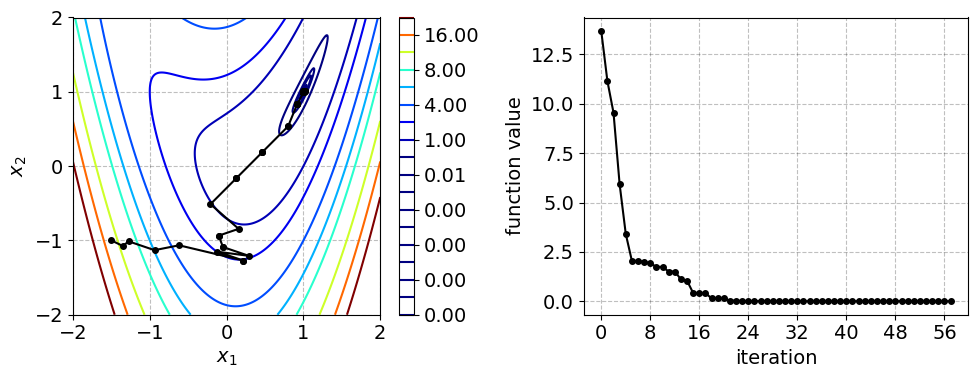

In [119]:
nit = 0 # global used in "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,
                           method='Nelder-Mead',
                           callback=collect, # call function collect() before each iteration
                           options={'disp':True}) # display the results
contour()

> **Note:** Does not require a gradient. Slow convergence close to target.
>
> **Iterations:** How many steps the algorithm has taken.
>
> **Function evaluations:** Will be higher than iterations. Used to compute next step.

We can also **print the information on results:**

In [120]:
print(result)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2.4876144250933352e-11
             x: [ 1.000e+00  1.000e+00]
           nit: 57
          nfev: 105
 final_simplex: (array([[ 1.000e+00,  1.000e+00],
                       [ 1.000e+00,  1.000e+00],
                       [ 1.000e+00,  1.000e+00]]), array([ 2.488e-11,  2.530e-10,  6.153e-10]))


We can also acess specific information of the result object: 

In [121]:
result.nit

57

**Newton** (with analytical hessian)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
         Hessian evaluations: 11


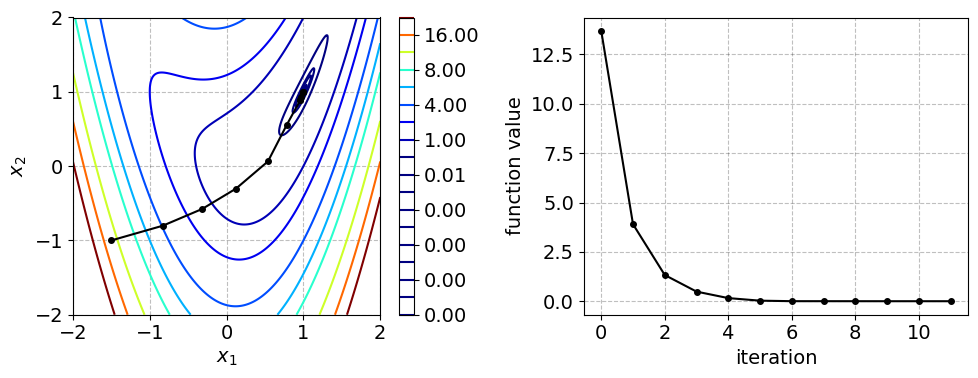

In [122]:
nit = 0 # global used in "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac,hess=rosen_hess,
                           method='Newton-CG',
                           callback=collect,
                           options={'disp':True})
contour()

> **Note:** Smoother and faster.

**Newton** (with numerical hessian computed by scipy)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 36
         Hessian evaluations: 0


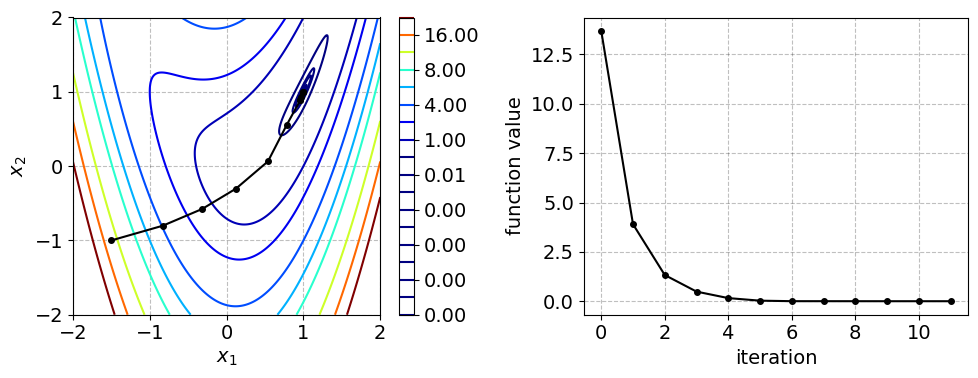

In [123]:
nit = 0 # global used in "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac,
                           method='Newton-CG',
                           callback=collect,
                           options={'disp':True})
contour()

> **Note:** Same as above, but gradient evaluations instead of hessian evaluations.

**BFGS** (with analytical gradient)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14


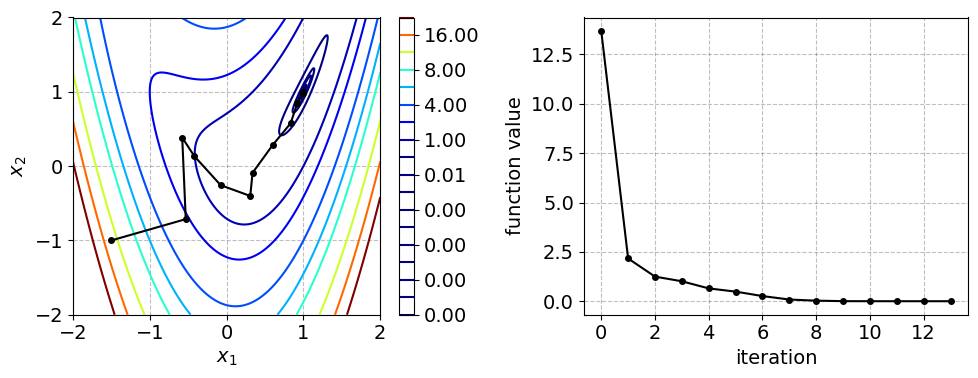

In [124]:
nit = 0 # global used in "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac,
                           method='BFGS',
                           callback=collect,
                           options={'disp':True})
contour()

> **Note:** Non-smooth, but fast. Very low number of function evaluations.

**BFGS** (with numerical gradient computed by scipy)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 42
         Gradient evaluations: 14


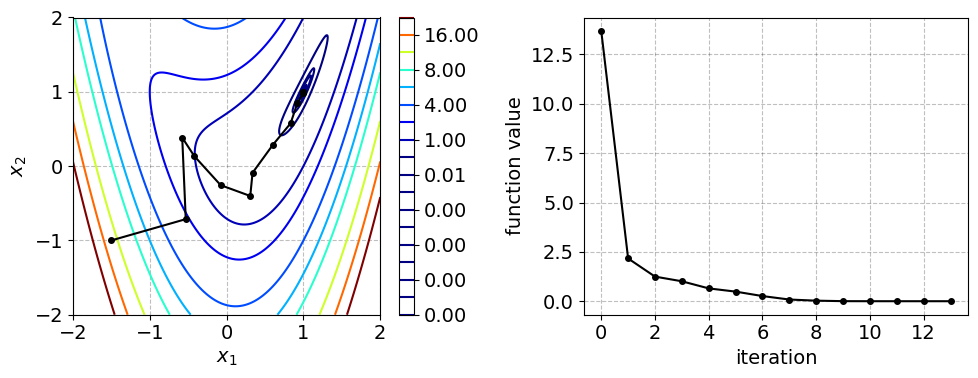

In [125]:
nit = 0 # global used in "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0, # no jac= specified
                           method='BFGS',
                           callback=collect,
                           options={'disp':True})
contour()

> **Note:** Same as above, but more function evaluations.

## 6. <a id='toc6_'></a>[Controling the optimizers](#toc0_)

> **Note:** See the settings for each optimizer in the [documention](https://docs.scipy.org/doc/scipy/reference/optimize.html).

We can lower the **tolerance**:

### 1e-08 ###

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 14
         Function evaluations: 45
         Gradient evaluations: 15


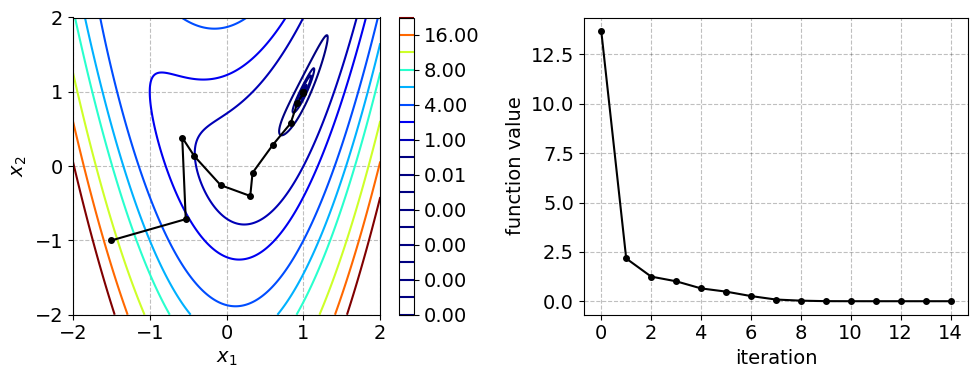

### 1e-10 ###

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 48
         Gradient evaluations: 16


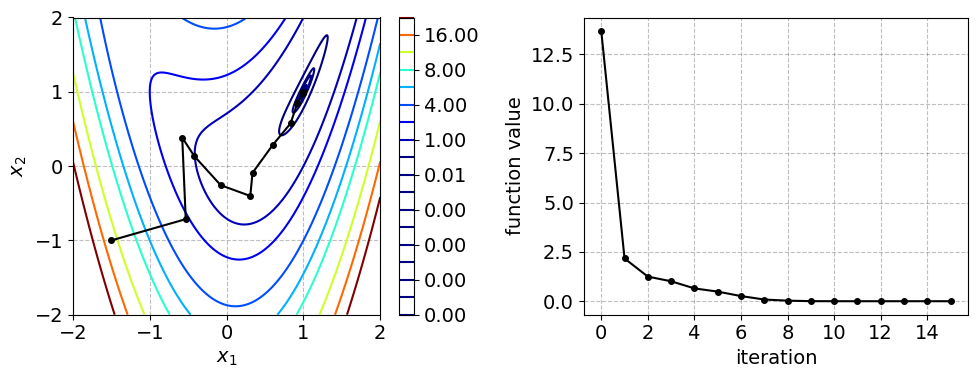

In [126]:
for gtol in [1e-8,1e-10]:

    print(f'### {gtol} ###\n')
          
    nit = 0
    x0 = [-1.5,-1]
    result = optimize.minimize(rosen,x0,
                            method='BFGS',
                            callback=collect,
                            options={'disp':True,'gtol':gtol}) # note this
    contour()
    plt.show()


We can change the **maximum number of iterations**:

         Current function value: 0.486266
         Iterations: 5
         Function evaluations: 18
         Gradient evaluations: 6


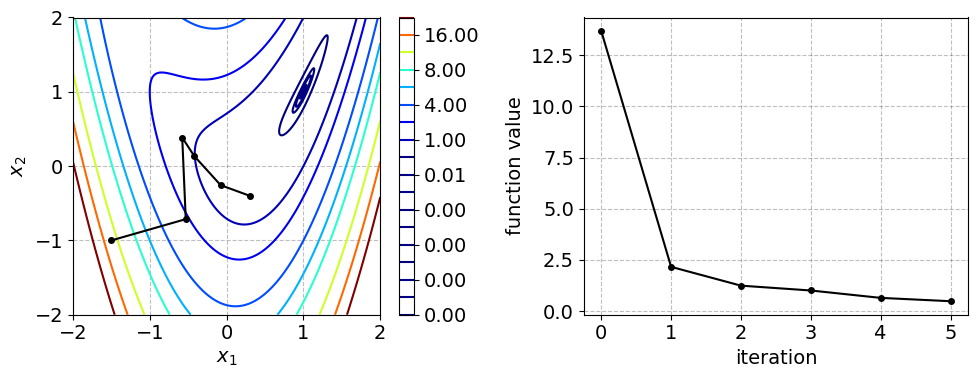

In [127]:
nit = 0
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,
                           method='BFGS',
                           callback=collect,
                           options={'disp':True,'maxiter':5}) # note this and warning
contour()

**Task:** Make the program stop if the optimizer is not sure it has found a maximum.

In [128]:
assert result.success, 'convergence not succesful'

AssertionError: convergence not succesful

## 7. <a id='toc7_'></a>[Example 2: Griewank function](#toc0_)

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**. How to avoid these?

In [ ]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

Test global minimum:

In [ ]:
griewank(np.zeros(2))

0.0

### 7.1. <a id='toc7_1_'></a>[3D plot](#toc0_)

In [-600,600] x [-600,600]:


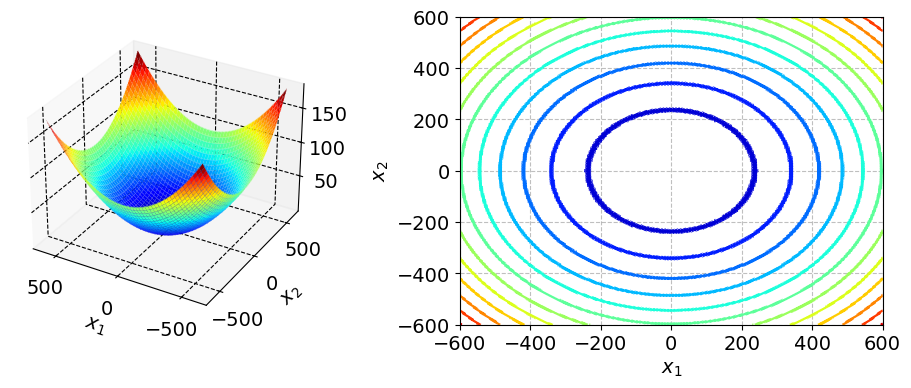

In [-5,5] x [-5,5]:


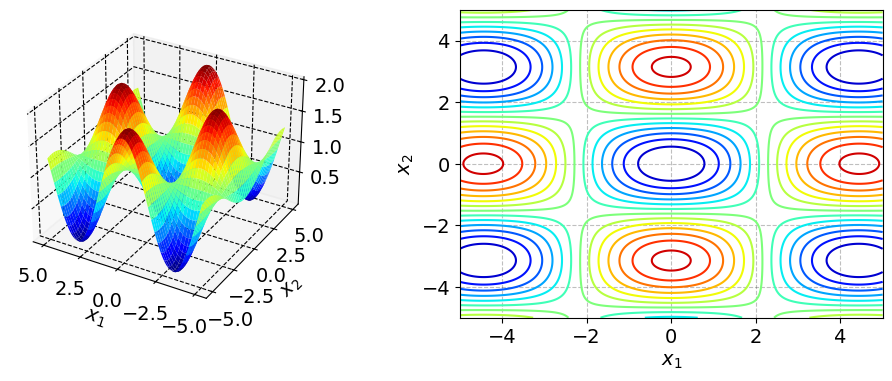

In [-1,1] x [-1,1]:


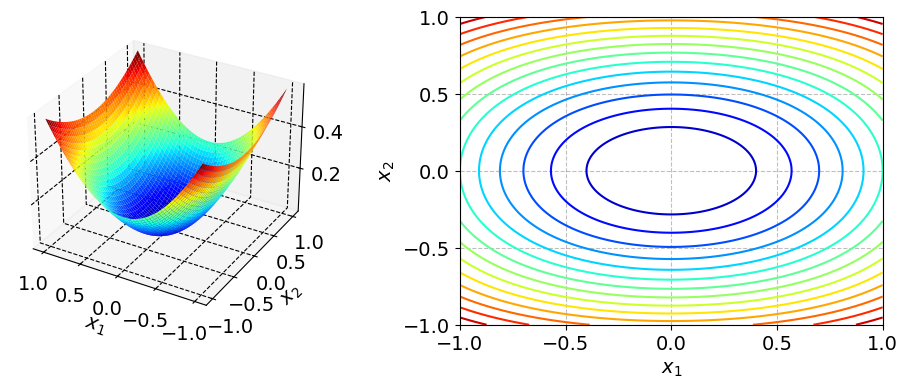

In [ ]:
for bound in [600,5,1]:
    
    print(f'In [{-bound},{bound}] x [{-bound},{bound}]:')
    
    # a. grids
    x1_vec = np.linspace(-bound,bound,1000)
    x2_vec = np.linspace(-bound,bound,1000)
    x1_grid_griewank,x2_grid_griewank = np.meshgrid(x1_vec,x2_vec,indexing='ij')
    griewank_grid = griewank_(x1_grid_griewank,x2_grid_griewank)

    # b. main
    fig = plt.figure(figsize=(12,4))
    
    # 3D
    ax = fig.add_subplot(1,2,1,projection='3d')
    cs = ax.plot_surface(x1_grid_griewank,x2_grid_griewank,griewank_grid,cmap=cm.jet)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.invert_xaxis()
    
    # contour
    ax = fig.add_subplot(1,2,2)
    cs = ax.contour(x1_vec,x2_vec,griewank_grid,levels=15,cmap=cm.jet)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    
    plt.show()

### 7.2. <a id='toc7_2_'></a>[Multi-start](#toc0_)

**Multi-start:** Draw many random starting values:

In [ ]:
np.random.seed(1986)
x0s = -600 + 1200*np.random.uniform(size=(5000,2)) # in [-600,600]
xs = np.empty((5000,2))
fs = np.empty(5000)

In [ ]:
print(f'min(x0s) = {np.min(x0s):.2f}, max(x0s) = {np.max(x0s):.2f}')

min(x0s) = -599.82, max(x0s) = 599.99


Try to solve with **BFGS** starting from each of these:

In [ ]:
fopt = np.inf
xopt = np.nan
for i,x0 in enumerate(x0s):
    
    # a. optimize
    result = optimize.minimize(griewank,x0,method='BFGS',tol=1e-8)
    xs[i,:] = result.x
    f = result.fun
    
    # b. print first 10 or if better than seen yet
    if i < 10 or f < fopt: # plot 10 first or if improving
        if f < fopt:
            fopt = f
            xopt = xs[i,:]
            
        print(f'{i:4d}: x0 = ({x0[0]:7.2f},{x0[1]:7.2f})',end='')
        print(f' -> converged at ({xs[i][0]:7.2f},{xs[i][1]:7.2f}) with f = {f:12.8f}')
        
# best solution
print(f'\nbest solution:\n x = ({xopt[0]:7.2f},{xopt[1]:7.2f}) -> f = {fopt:12.8f}')

   0: x0 = (  82.65,-507.19) -> converged at (  81.64,-505.97) with f =  65.73498053
   1: x0 = ( 130.18, 477.00) -> converged at ( 128.74, 474.90) with f =  60.58705906
   2: x0 = (  53.89, 243.27) -> converged at (  53.38, 244.11) with f =  15.62554357
   3: x0 = (-136.64, 181.99) -> converged at (-135.02, 181.98) with f =  12.84702853
   4: x0 = ( 228.06, 262.36) -> converged at ( 229.22, 261.86) with f =  30.30292144
   5: x0 = ( 228.22, 368.17) -> converged at ( 229.22, 368.38) with f =  47.10365932
   6: x0 = (-259.50, 309.21) -> converged at (-257.48, 310.69) with f =  40.73856783
   7: x0 = (-230.91, -74.51) -> converged at (-229.22, -75.45) with f =  14.56692544
   8: x0 = (  63.24, -80.57) -> converged at (  62.80, -79.89) with f =   2.58374459
   9: x0 = (  93.14, 470.65) -> converged at (  94.20, 470.47) with f =  57.61100119
  57: x0 = ( -28.14,  -4.62) -> converged at ( -28.26,  -4.44) with f =   0.20468948
 297: x0 = (  -3.72,  -4.04) -> converged at (  -3.14,  -4.44) wi

The solver, wrongly, **converges to many of the local minima**:

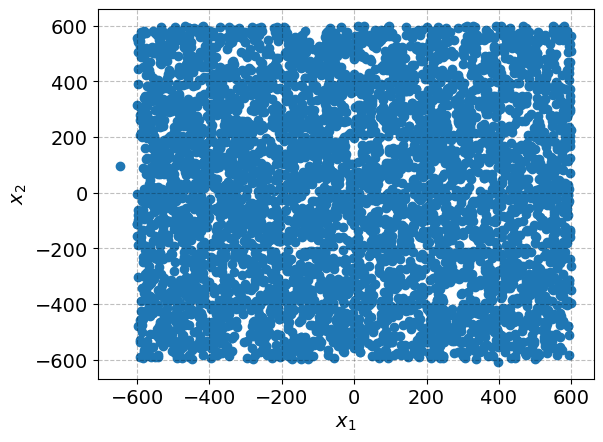

In [129]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(xs[:,0],xs[:,1])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

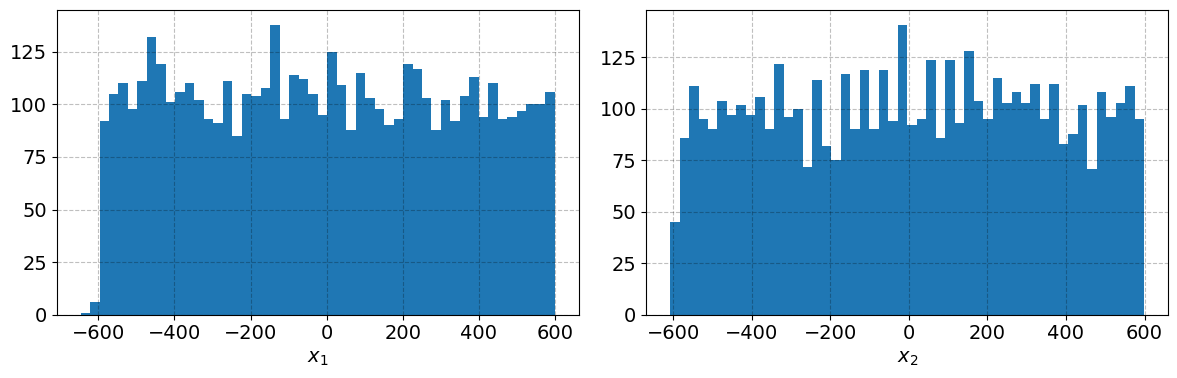

In [ ]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.hist(xs[:,0],bins=50)
ax.set_xlabel('$x_1$')

ax = fig.add_subplot(1,2,2)
ax.hist(xs[:,1],bins=50)
ax.set_xlabel('$x_2$')

fig.tight_layout()

### 7.3. <a id='toc7_3_'></a>[Is there a better solution than multi-start?](#toc0_)

**In short:** No.

**Potential improvement:** Use information from previous run to determine, where to look next. Fundamental trade-off between:

1. **Exploitation.** Focus on areas where previous evaluations returned low function values.
2. **Exploration.** Focus on completely new areas. 

**Heuristic:** If the same optimum is obtained for many starting values, this is a good sign for it being the global optimum.

**Further discussion**: [Benchmarking Global Optimizers](https://www.nber.org/papers/w26340) ([code](https://github.com/serdarozkan/TikTak#tiktak))